In [1]:
import pandas as pd

In [38]:
train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')
sub = pd.read_csv('./open/sample_submission.csv')

In [39]:
train['대출등급'].value_counts()

B    28817
C    27623
A    16772
D    13354
E     7354
F     1954
G      420
Name: 대출등급, dtype: int64

In [40]:
train['대출기간'] = train['대출기간'].apply(lambda x:x[:3])
train['대출기간'] = train['대출기간'].astype('int64')
test['대출기간'] = test['대출기간'].apply(lambda x:x[:3])
test['대출기간'] = test['대출기간'].astype('int64')

trans = {'1 year':1,
 '1 years':1,
 '10+ years':10,
 '10+years':10,
 '2 years':2,
 '3':3,
 '3 years':3,
 '4 years':4,
 '5 years':5,
 '6 years':6,
 '7 years':7,
 '8 years':8,
 '9 years':9,
 '< 1 year':0.5,
 '<1 year':0.5,
 'Unknown':0}
train['근로기간'] = [trans[i] for i in train['근로기간'].values]
test['근로기간'] = [trans[i] for i in test['근로기간'].values]


In [42]:
train['대출목적'].value_counts()

부채 통합     55150
신용 카드     24500
주택 개선      6160
기타         4725
주요 구매      1803
의료         1039
자동차         797
소규모 사업      787
이사          506
휴가          466
주택          301
재생 에너지       60
Name: 대출목적, dtype: int64

In [54]:
train[train['부채_대비_소득_비율'] > 100]

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
12498,TRAIN_12498,4440000,36,0.0,MORTGAGE,0,9999.00,20,신용 카드,2,205356,85884.0,0.0,0.0,C
29129,TRAIN_29129,14400000,36,0.0,RENT,1440000,672.52,13,부채 통합,0,595344,442860.0,0.0,0.0,E
62125,TRAIN_62125,18000000,36,0.0,MORTGAGE,10440000,120.66,26,부채 통합,0,396456,200328.0,0.0,0.0,D
62765,TRAIN_62765,7860000,36,0.0,MORTGAGE,2124000,1092.52,25,신용 카드,2,0,0.0,0.0,0.0,D
81970,TRAIN_81970,14400000,60,0.0,MORTGAGE,11694000,125.25,53,부채 통합,0,302736,412116.0,0.0,0.0,D
83954,TRAIN_83954,24000000,60,0.5,RENT,32400000,100.09,16,부채 통합,0,248064,339732.0,0.0,0.0,E


C:\Users\User\AppData\Local\Temp\ipykernel_20788\4217466554.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[train['대출등급'] == tar]['부채_대비_소득_비율'])
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52292 (\N{HANGUL SYLLABLE CAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\pylabtools.

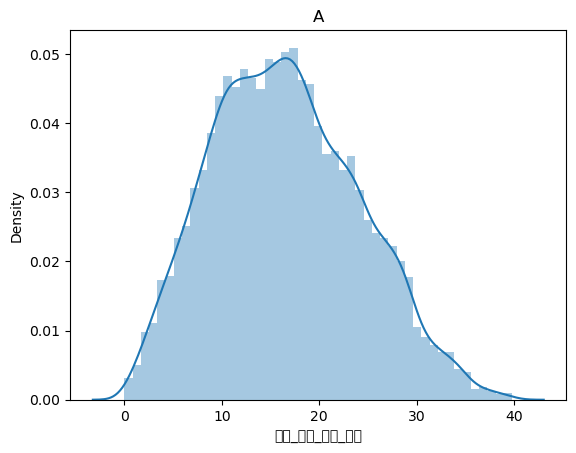

C:\Users\User\AppData\Local\Temp\ipykernel_20788\4217466554.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[train['대출등급'] == tar]['부채_대비_소득_비율'])
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52292 (\N{HANGUL SYLLABLE CAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\pylabtools.

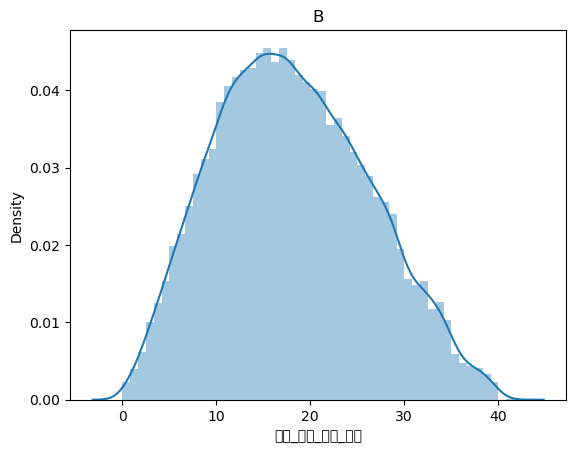

C:\Users\User\AppData\Local\Temp\ipykernel_20788\4217466554.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[train['대출등급'] == tar]['부채_대비_소득_비율'])
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52292 (\N{HANGUL SYLLABLE CAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\pylabtools.

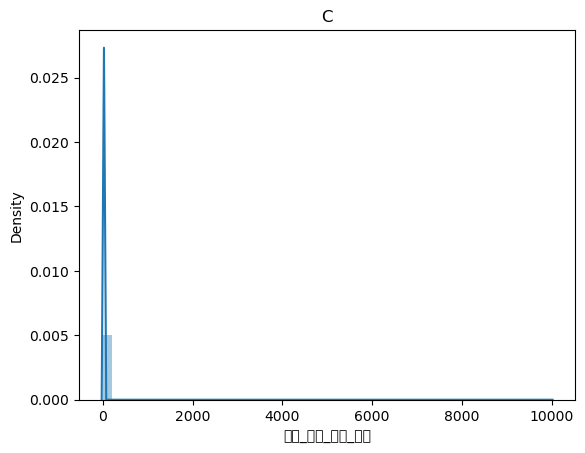

C:\Users\User\AppData\Local\Temp\ipykernel_20788\4217466554.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[train['대출등급'] == tar]['부채_대비_소득_비율'])
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52292 (\N{HANGUL SYLLABLE CAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\pylabtools.

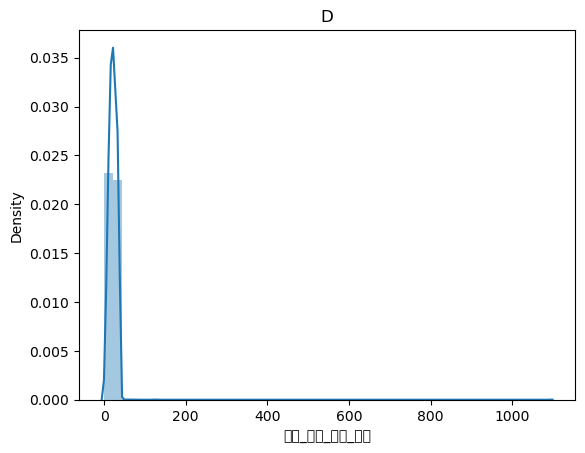

C:\Users\User\AppData\Local\Temp\ipykernel_20788\4217466554.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[train['대출등급'] == tar]['부채_대비_소득_비율'])
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52292 (\N{HANGUL SYLLABLE CAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\pylabtools.

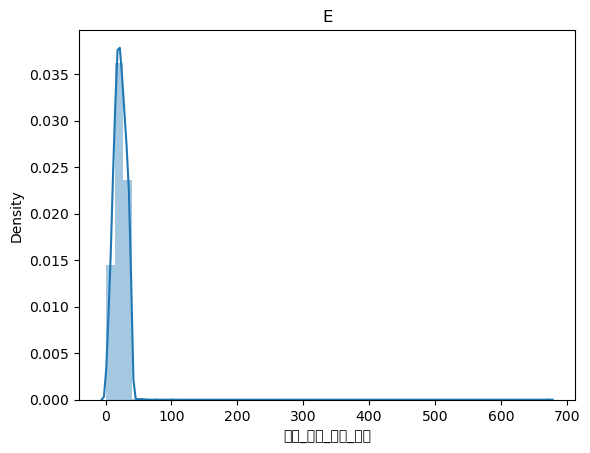

C:\Users\User\AppData\Local\Temp\ipykernel_20788\4217466554.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[train['대출등급'] == tar]['부채_대비_소득_비율'])
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52292 (\N{HANGUL SYLLABLE CAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\pylabtools.

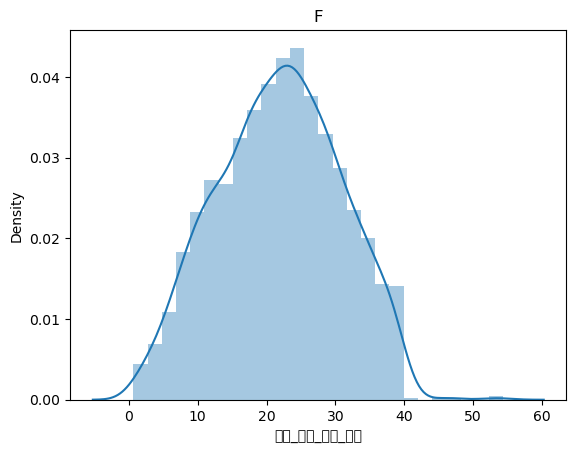

C:\Users\User\AppData\Local\Temp\ipykernel_20788\4217466554.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[train['대출등급'] == tar]['부채_대비_소득_비율'])
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52292 (\N{HANGUL SYLLABLE CAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\pylabtools.

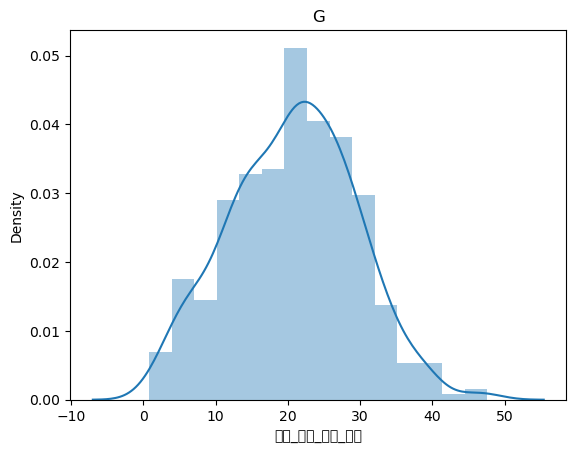

In [52]:
import seaborn as sns
target = ['A','B','C','D','E','F','G']
for tar in target:
    plt.title(tar)
    sns.distplot(train[train['대출등급'] == tar]['부채_대비_소득_비율'])
    plt.show()